In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Statevector, state_fidelity
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import Parameter # To enable parameterized circuits
from qiskit.circuit.library import SwapGate
from qiskit_aer import AerSimulator

import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from math import pi, sqrt
from matplotlib import pyplot as plt

# 01 (Alice X Gate)

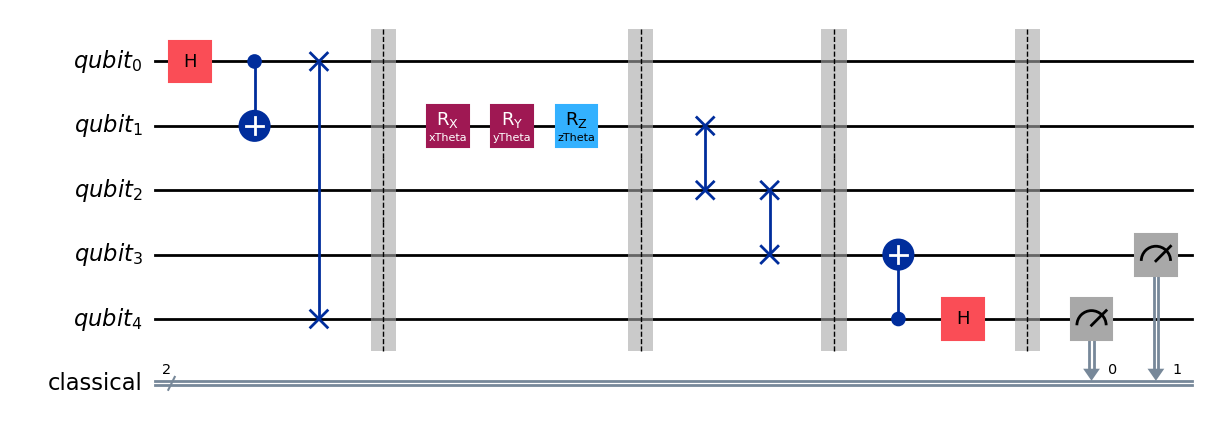

In [2]:
bNum = 2

xTheta = Parameter('xTheta')
yTheta = Parameter('yTheta')
zTheta = Parameter('zTheta')



num_data_qubits = bNum+3
num_data_cbits = 2

# Create qubit and classical data bit registers (you can create and name additional registers if it's useful for bookkeeping)
data_qubits = QuantumRegister(num_data_qubits, "qubit")
classical_data = ClassicalRegister(num_data_cbits, "classical")

# Create circuit object
qc = QuantumCircuit(data_qubits,  classical_data)

# Create empty lists to store qubits and classical bits for convenient access
qdata = []; cdata = []; 

# Store qubits from data_qubit register in list for convenient access
qdata[:] = data_qubits

# Store classical bits from classical_data register in list for convenient access
cdata[:] = classical_data
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.h(0) #This is state to be transported
qc.cx(0,1)
qc.swap(0,4)
qc.barrier()

# qc.id(1)
qc.rx(xTheta,1)
qc.ry(yTheta,1)
qc.rz(zTheta,1)
# qc.x(1)
# qc.z(1)
qc.barrier()

for i in range (1, bNum + 1):
    qc.swap(i, i+1)
qc.barrier()

qc.cx(bNum+2, bNum + 1)
qc.h(bNum+2)
qc.barrier()

qc.measure(bNum + 2, 0)
qc.measure(bNum + 1, 1)


qc.draw('mpl')

In [3]:

def send(bits2):
    params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    # if (bits2=='00'):
    #     params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    if (bits2=='10'):
        params = {zTheta: 0,     yTheta: 0,     xTheta: pi}
    if (bits2 == '01'):
        params = {zTheta: pi,     yTheta: 0, xTheta: 0}
    if (bits2=='11'):
        params = {zTheta: pi, yTheta: 0,     xTheta: pi}
    return params
def send_string(bits):
    param_sets = []
    if (len(bits)%2==1):
        bits=f"{bits}0"
    for i in range(0,len(bits),2):
        bits2 = bits[i:i+2]
        param_sets.append(send(bits2))
    return param_sets



In [34]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='0f573ee83296aa35a35af1bc2d8d5d029e023c10fca3815b7a6cc4e48062062cd62cf423c4f0e0e3fbecbc55c5b49f87ad184bca13d05162a3c478eaee7d58f0'
)

C:\Users\caleb\AppData\Local\Temp\ipykernel_47216\2577213465.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


In [85]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator
backend = FakeSherbrooke()
#backend = AerSimulator()
#backend = service.backend('ibm_brisbane')
sampler = Sampler(backend)

# Create the "pass manager" that will perform the transpilation
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

# Run the pass manager to generate the transpiled circuit
transpiled_circuit = pm.run(qc)
#transpiled_circuit.draw('mpl')

In [88]:
file = open("quRNG_01.txt","r")
content = file.read()
param_sets = send_string(content)
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
job2 = sampler.run(bound_circuits, shots = 10)


In [89]:
def recieve_string(job):
    message = ""
    for i in range(len(job.result())):
        result = job.result()[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
                max=result[res]
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message

In [ ]:
result = recieve_string(job2)
errors = 0
for i in range(len(content)):
    if (content[i]!=result[i]):
        errors+=1
print(100*errors/len(content))
# print(job2.result()[0].data.classical.get_counts())
# print(result)


0.06590509666080843


In [90]:
errors2 = []
shots = [1,2]
for i in shots:
    job2 = sampler.run(bound_circuits, shots = i)
    result = recieve_string(job2)
    error_num = 0
    for i in range(len(content)):
        if (content[i]!=result[i]):
            error_num+=1
    errors2.append(100*error_num/len(content))
print(errors2)

[14.707820738137082, 13.884007029876978]


In [ ]:
import scipy.optimize as opt
def fit_equation (x, a, b, c):
    y = a*(np.exp((-b)*x))+c
    return y
shots_fixed = [x for i, x in enumerate(shots) if i != 1]
errors_fixed = [x for i, x in enumerate(errors) if i != 1]
param, cov = opt.curve_fit(fit_equation, shots_fixed, errors_fixed)


[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


C:\Users\caleb\AppData\Local\Temp\ipykernel_47216\1173672898.py:3: RuntimeWarning: overflow encountered in exp
  y = a*(np.exp((-b)*x))+c


In [83]:
print(param[0])

19.831562228168433


Text(0, 0.5, 'Bit error %')

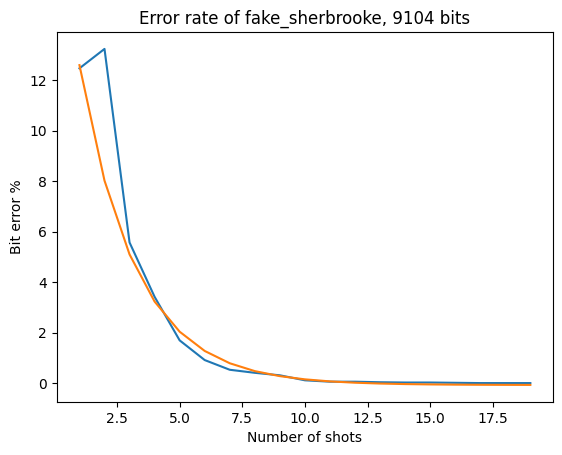

In [84]:
plt.plot(shots, errors)
plt.plot(shots, fit_equation(shots, param[0], param[1], param[2]))
plt.title("Error rate of fake_sherbrooke, 9104 bits")
plt.xlabel("Number of shots")
plt.ylabel("Bit error %")

In [31]:
print(len(result))

9104


In [80]:
print(content)

0000111100111101111100111011110111111101001001110111110011011100111110111111011111011111000011010100010001111111101110111101000101100010101011111010111010111100101101110111100101011111101111011011111111111111011011111111100111111011010001011101111010001100011101111000111011111111101101111010111111111000111100111011000000111111111110110111011111101111110110101111011111111100110110110110110110110111001110010010010001111111110001010101011110111011110001101001101011010110101100010111111111110111011111111011001101101111101101110111111001011010011011110100111111111101001101111110111000101100001110111111001111100001111101110101111100111111110010111101111101110110001001101110010111110111111110110101100111100001011111101011111110001011101111111111010110011101111110111111101011011001111101111110111001101111111111111011111101111101010011011111010110110110110011111111011101011000111101110010110011111011111011111011111111101110111110001010111010100110100110101101001111001010011011010111000111110001

In [ ]:
from PIL import Image
img = Image.open("C:\\Users\\caleb\\Pictures\\Screenshots\\Screenshot 2025-04-28 134719.png")


In [70]:
with open("C:\\Users\\caleb\\Pictures\\Screenshots\\Screenshot 2025-04-28 134719.png", encoding = 'ISO-8859-1') as file:
    file_content = file.read()
print(file_content[423:-14])

 ü6fZ|Ý
  Â  7  o Þ   ¼  @x @ð  á
  Â  7  o Þ   ¼  @x @@ëõ®7]i·êë°tÝrvº]WÝzÞî¸=Þî¸fbm£)[;o¥»ÞÔðAÛåávµ¼<µëé]'°x&ÍTxóqÌ;¼»ë_dkszõöæöÀâÞtÊÅùf^wêé]'°x7Ê¼Ã{Þúû£r|r_ú£z>¨y[ÎX<fêo  HÞ   ¼  @x @ð  á
  Â  7  o Þ   ¼  @x @ð  á
  Â  7  o Þ   ¼   õz×®´[õuX:ÃN¹8ß,ÃëN=ÍÄËs»<Ü®Ñs»f¢·;.G¥·;®§¶¶Ñ­·Ò]oê	bF_ïÏ§ùÜóòíÜºí¹ÕßãûÒ?ÕðL©ðæã÷w^Èt×¿ìÚloo9_øXæýâ=/óz¡Þ°x7üËn9;Ý.«n=}jð,÷çÏ¹/añL©o¼  Ax @ð  á
  Â  7  o Þ   ¼  @x @ð  á
  Â  7  o Þ   ¼  @x @ð  á
  Â  Z¯w½éJ»U_*ÃN¹8ß,ÃëN=-´çvy¸]-£çv=ÍDTOîKÿ`TOðÍèëÿáËÓ|þ¿Ý7³½?»ëMÙÚy+këM=-´ÞÞ¸=Þî¸dÒL7üZóyWüDxókÌûÅu^/½ÝåØµ//Ý%{aLxÃ'0¸ì³Óí2¸êÖÓo~yÿÎÿo`V&ÍÔ7Þ   ¼  @x @ð  á
  Â  7  o Þ   ¼  @x @ð  á
  Â  7  o Þ   ¼  @x @@ëõ®7]i·êë|b£çvy¸]-/OízúÔÖ6²µóVºëM=-´áM§\oáu§f¢·7.G¥·;®'øfpÙ-g§ÛepÕ­§è®¹?×f|úÿfeÒL7¿oÞ¡¶¬õ<ï©e}!!kÞáÝÛÏýéÿáÍwÍû¹¬úû£r|r_ú£z~Á¼Ï÷'°è&ÍÔ7Þ   ¼  @x @ð

In [71]:
with open("C:\\Users\\caleb\\Pictures\\Screenshots\\Screenshot 2025-04-28 134719.png", 'rb') as file:
    file_content = file.read()
file_content = file_content[423:-14]
bit_string = ''.join(f'{byte:08b}' for byte in file_content)

In [ ]:

#file_string = str(file_content)
#print(bit_string[0:2])

10


In [72]:
param_sets = send_string(bit_string)
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
job2 = sampler.run(bound_circuits, shots=1)

In [41]:
pixels = recieve_string(job2)

img = np.reshape(list(pixels), img.size)
plt.imshow(img, interpolation='nearest')
plt.show()

ValueError: cannot reshape array of size 55856 into shape (734,735)